In [139]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

import datetime

# External dependencies
import wavio
import soundsig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from soundsig.sound import spectrogram, plot_spectrogram

# Modules from this repository
from load_data import load_data, load_stimulus
from plotting import color_by_reward, plot_data, set_oddsratio_yticks
from stats import false_discovery, get_odds_ratio_matrix, fisher_exact, jackknife

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
df = load_data()

## Summarize performance on an overall level

In [143]:
summary_df_rows = []

for ctx, condition in [
            ("SovsSo_8v8_d2", "None"),
            ("DCvsDC_6v6_d2", "None"),
            ("AllvsAll_28v28", "None"),
            ("AllvsAll_28v28", "MonthLater"),
    ]:
    ctx_df = df[(df["Test Context"] == ctx) & (df["Condition"] == condition)]

    for subject in ctx_df.Subject.unique():
        subject_df = ctx_df[ctx_df.Subject == subject]
        
        rewarded_set = subject_df[subject_df["Stimulus Class"] == "Rewarded"]
        nonrewarded_set = subject_df[subject_df["Stimulus Class"] == "Nonrewarded"]
        
        table = get_odds_ratio_matrix(nonrewarded_set, rewarded_set, "Interrupt")
        odds, interval95, p_value = fisher_exact(table, side="greater")

        summary_df_rows.append(
            [
                subject, ctx, condition, odds, interval95[0], interval95[1], p_value, 
            ]
        )
        
summary_df = pd.DataFrame(
    summary_df_rows,
    columns=["Subject", "Test Context", "Condition", "Odds Ratio", "95 CI Lower", "95 CI Upper", "p-value"]
)

In [144]:
# Stats
song_points = summary_df[summary_df["Test Context"] == "SovsSo_8v8_d2"]["Odds Ratio"]
dc_points = summary_df[summary_df["Test Context"] == "DCvsDC_6v6_d2"]["Odds Ratio"]

song_mean = 2 ** np.mean(np.log2(song_points))
dc_mean = 2 ** np.mean(np.log2(dc_points))

song_interval_95 = [
    2 ** (np.mean(np.log2(song_points)) - (2 * np.std(np.log2(song_points)) / np.sqrt(len(song_points)))),
    2 ** (np.mean(np.log2(song_points)) + (2 * np.std(np.log2(song_points)) / np.sqrt(len(song_points))))
]
dc_interval_95 = [
    2 ** (np.mean(np.log2(dc_points)) - (2 * np.std(np.log2(dc_points)) / np.sqrt(len(dc_points)))),
    2 ** (np.mean(np.log2(dc_points)) + (2 * np.std(np.log2(dc_points)) / np.sqrt(len(dc_points))))
]

# Paired t-test
significance = scipy.stats.ttest_rel(
    np.log2(song_points),
    np.log2(dc_points),
)
print(song_mean, dc_mean, significance)

15.536841772162942 8.444150666568587 Ttest_relResult(statistic=3.3258178032333743, pvalue=0.003760659167624473)


<ErrorbarContainer object of 3 artists>

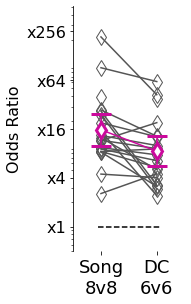

In [145]:
fig = plt.figure(figsize=(2, 4.5))

for subject in summary_df.Subject.unique():
    song_row = summary_df[(summary_df.Subject == subject) & (summary_df["Test Context"] == "SovsSo_8v8_d2")]
    dc_row = summary_df[(summary_df.Subject == subject) & (summary_df["Test Context"] == "DCvsDC_6v6_d2")]

    song_or = song_row.iloc[0]["Odds Ratio"] if len(song_row) else np.nan
    dc_or = dc_row.iloc[0]["Odds Ratio"] if len(dc_row) else np.nan

    plt.plot(
        [0, 1],
        [song_or, dc_or],
        marker="d",
        color="#555555",
        markerfacecolor="none",
        markersize=12,
        zorder=0,
    )

set_oddsratio_yticks(plt.gca(), 9, -1)
plt.xlim(-0.5, 1.5)
plt.xticks([0, 1], ["Song\n8v8", "DC\n6v6"], fontsize=18)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.errorbar(
    [0, 1],
    [song_mean, dc_mean],
    yerr=[
        [song_mean - song_interval_95[0], dc_mean - dc_interval_95[0]],
        [song_interval_95[1] - song_mean, dc_interval_95[1] - dc_mean]
    ],
    marker="d",
    color="#CB0A9C",
    capsize=10,
    markerfacecolor="White",
    markersize=12,
    markeredgewidth=3,
)




## Summarize performance on a per-vocalizer level

In [146]:
stim_level_df_rows = []

for ctx in ["SovsSo_8v8_d2", "DCvsDC_6v6_d2", "AllvsAll_28v28"]:
    ctx_df = df[(df["Test Context"] == ctx) & (df["Condition"] == "None")]

    for subject in ctx_df.Subject.unique():
        subject_df = ctx_df[ctx_df.Subject == subject]
        
        stim_groups = subject_df.sort_values("Subject").groupby([
            "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class"
        ])
        
        for (vocalizer, call_type, rewarded), subdf in stim_groups:
            # First compute a baseline that is an average interruption rate,
            # correct for the fact that nonrewarded stimuli are played 4x more frequently
            # than rewarded by undersampling the non-rewarded trials
            
            rewarded_base = subject_df[subject_df["Stimulus Class"] == "Rewarded"]
            
            # There are much more non-rewarded trials. We sample non-rewarded trials such that
            # we use an equal number of rewarded and non-rewarded trials, and then take multiple
            # samples to reduce the error introduced by this method.
            unrewarded_bases = []
            n_iterations = 1
            for _ in range(n_iterations):
                unrewarded_bases.append(subject_df[subject_df["Stimulus Class"] == "Nonrewarded"].sample(
                    n=len(rewarded_base),
                    replace=False
                ))
            
            baseline_sets = [
                pd.concat([rewarded_base, unrewarded_base]) for unrewarded_base in unrewarded_bases
            ]
            
            repeated_odds = np.zeros(n_iterations)
            repeated_intervals = np.zeros(shape=(n_iterations, 2))
            repeated_pvalues = np.zeros(n_iterations)
            
            for i, baseline_set in enumerate(baseline_sets):
                # Compute the odds ratio for the contingency table
                #
                #  |  Rewarded Trials  |  Random Trials  |
                #  |-------------------|-----------------|
                #  |  Interrupted      |  Interrupted    |
                #  |  Waited           |  Waited         |
                table = get_odds_ratio_matrix(subdf, baseline_set, "Interrupt")
                odds, interval95, p_value = fisher_exact(table, side="greater" if rewarded == "Nonrewarded" else "less")
                repeated_odds[i] = odds
                repeated_intervals[i] = interval95
                repeated_pvalues[i] = p_value
                
            # Add a row to the summary df
            stim_level_df_rows.append(
                [subject, ctx, vocalizer, call_type, rewarded, np.mean(repeated_odds),
                    np.mean(repeated_intervals[:, 0]), np.mean(repeated_intervals[:, 1]),
                    np.mean(repeated_pvalues),
                ]
            )
    
stim_level_df = pd.DataFrame(
    stim_level_df_rows,
    columns=["Subject", "Test Context", "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class",
             "Odds Ratio", "95 CI Lower", "95 CI Upper", "p-value"]
)

In [147]:
for _, subj_df in stim_level_df.groupby(["Subject", "Test Context"]):
    display(subj_df.sort_values(["Stimulus Class", "Stimulus Call Type", "Stimulus Vocalizer"]))

,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
436,BlaGre1349M,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,6.298581,3.941777,inf,1.164098e-13
438,BlaGre1349M,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,8.059088,4.787059,inf,2.155854e-15
439,BlaGre1349M,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,6.829685,4.228766,inf,1.773254e-14
440,BlaGre1349M,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,13.296296,7.217226,inf,7.373027e-20
444,BlaGre1349M,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,8.700457,5.075011,inf,7.882481e-16
445,BlaGre1349M,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,12.575931,7.026881,inf,2.934413e-20
437,BlaGre1349M,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.080102,0.000000,0.240056,3.036291e-07
441,BlaGre1349M,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.150624,0.000000,0.392808,8.561117e-05
442,BlaGre1349M,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.221975,0.000000,0.491834,4.098172e-04
443,BlaGre1349M,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.049748,0.000000,0.199541,7.341041e-08


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
176,BlaGre1349M,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,9.719405,6.004962,inf,2.668592e-21
177,BlaGre1349M,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,3.060983,2.141554,inf,6.045706e-08
178,BlaGre1349M,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,8.361889,5.235496,inf,3.341989e-19
179,BlaGre1349M,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,5.819599,3.860304,inf,2.873582e-15
181,BlaGre1349M,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,6.884700,4.474598,inf,2.626781e-17
188,BlaGre1349M,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,9.795866,5.966577,inf,1.189359e-20
189,BlaGre1349M,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,10.688006,6.510252,inf,2.154608e-22
190,BlaGre1349M,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,4.793671,3.249453,inf,4.651570e-13
180,BlaGre1349M,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.148341,0.000000,0.379660,2.937117e-05
182,BlaGre1349M,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,0.092676,0.000000,0.275805,1.110633e-06


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
401,BluYel2571F,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,3.004421,1.834235,inf,6.981499e-05
405,BluYel2571F,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,2.611336,1.635918,inf,2.926469e-04
406,BluYel2571F,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,1.801365,1.162563,inf,1.557728e-02
407,BluYel2571F,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,5.612097,3.079757,inf,3.211881e-08
410,BluYel2571F,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,0.675529,0.453400,inf,9.596462e-01
411,BluYel2571F,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,1.107943,0.724526,inf,3.893415e-01
400,BluYel2571F,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.255963,0.000000,0.548142,1.234353e-03
402,BluYel2571F,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.901758,0.000000,1.868568,5.001263e-01
403,BluYel2571F,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,0.643709,0.000000,1.334588,2.219287e-01
404,BluYel2571F,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,0.482034,0.000000,0.984391,6.686704e-02


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
132,BluYel2571F,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,20.281106,8.108648,inf,7.530133e-16
134,BluYel2571F,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,3.762162,2.312181,inf,9.683987e-07
135,BluYel2571F,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,2.222572,1.431891,inf,1.428338e-03
136,BluYel2571F,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,8.667692,4.650475,inf,2.483276e-12
137,BluYel2571F,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,7.566386,4.174333,inf,1.730771e-11
138,BluYel2571F,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,13.153846,6.570103,inf,6.944082e-16
139,BluYel2571F,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,4.398109,2.680003,inf,4.973241e-08
143,BluYel2571F,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,4.106849,2.497144,inf,2.609011e-07
128,BluYel2571F,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.066181,0.000000,0.269341,7.312551e-06
129,BluYel2571F,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.301493,0.000000,0.691886,9.213349e-03


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
424,GraWhi4040F,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,1.894669,1.322853,inf,2.001807e-03
426,GraWhi4040F,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,2.043440,1.416552,inf,8.078154e-04
427,GraWhi4040F,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,2.760858,1.896090,inf,2.995134e-06
428,GraWhi4040F,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,4.429898,2.905661,inf,2.118525e-10
432,GraWhi4040F,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,3.385763,2.299531,inf,4.226562e-08
433,GraWhi4040F,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,3.463152,2.354195,inf,2.108053e-08
425,GraWhi4040F,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.512674,0.000000,0.946272,4.561237e-02
429,GraWhi4040F,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.861919,0.000000,1.623859,4.172556e-01
430,GraWhi4040F,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.069422,0.000000,0.279529,5.205313e-06
431,GraWhi4040F,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.338066,0.000000,0.686191,5.430250e-03


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
160,GraWhi4040F,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,4.353066,2.597427,inf,6.650393e-07
161,GraWhi4040F,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,1.836749,1.162700,inf,2.098834e-02
162,GraWhi4040F,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,4.032137,2.506960,inf,4.873659e-07
163,GraWhi4040F,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,2.280274,1.441517,inf,2.274469e-03
165,GraWhi4040F,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,1.533333,0.979009,inf,7.681870e-02
172,GraWhi4040F,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,6.490222,3.861826,inf,1.138288e-10
173,GraWhi4040F,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,1.602740,1.011407,inf,6.176787e-02
174,GraWhi4040F,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,0.906278,0.557321,inf,6.932768e-01
164,GraWhi4040F,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.047803,0.000000,0.508751,4.075993e-04
166,GraWhi4040F,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,0.427609,0.000000,1.150734,9.036135e-02


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
473,GreBla3404M,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,2.356355,1.563292,inf,0.000338
477,GreBla3404M,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,3.204897,2.008821,inf,0.000016
478,GreBla3404M,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,1.353645,0.907567,inf,0.130736
479,GreBla3404M,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,2.900667,1.887582,inf,0.000023
482,GreBla3404M,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,1.120659,0.750242,inf,0.366879
483,GreBla3404M,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,1.494258,0.996094,inf,0.064618
472,GreBla3404M,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.268085,0.000000,0.725146,0.012927
474,GreBla3404M,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.755476,0.000000,1.504502,0.315300
475,GreBla3404M,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,1.018250,0.000000,2.116374,0.602935
476,GreBla3404M,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,0.157065,0.000000,0.483388,0.000887


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
228,GreBla3404M,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,2.443223,1.438388,inf,3.648368e-03
230,GreBla3404M,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,9.412955,4.471415,inf,6.943078e-09
231,GreBla3404M,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,2.534597,1.395957,inf,7.549238e-03
232,GreBla3404M,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,1.888591,1.064848,inf,4.692152e-02
233,GreBla3404M,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,3.270325,1.824988,inf,4.766217e-04
234,GreBla3404M,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,3.136925,1.793561,inf,4.603468e-04
235,GreBla3404M,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,1.588777,0.905375,inf,1.180194e-01
239,GreBla3404M,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,1.447552,0.785787,inf,2.104901e-01
224,GreBla3404M,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.059291,0.000000,0.644461,2.760762e-03
225,GreBla3404M,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.461996,0.000000,1.301708,1.430206e-01


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
532,GreBla5671F,AllvsAll_28v28,BlaBla0506,DC,Nonrewarded,4.801250,3.139761,inf,8.844287e-12
534,GreBla5671F,AllvsAll_28v28,BlaLbl8026,DC,Nonrewarded,4.016124,2.725082,inf,1.052547e-10
536,GreBla5671F,AllvsAll_28v28,BluRas61dd,DC,Nonrewarded,3.811656,2.620014,inf,1.559294e-10
538,GreBla5671F,AllvsAll_28v28,GraGra0201,DC,Nonrewarded,4.409508,2.975450,inf,7.347251e-12
539,GreBla5671F,AllvsAll_28v28,GraLbl0457,DC,Nonrewarded,3.772723,2.552975,inf,1.182227e-09
541,GreBla5671F,AllvsAll_28v28,GreGre6364,DC,Nonrewarded,2.827434,1.998729,inf,1.731935e-07
542,GreBla5671F,AllvsAll_28v28,GreOra1817,DC,Nonrewarded,4.085918,2.776604,inf,4.423151e-11
552,GreBla5671F,AllvsAll_28v28,LblBla4548,DC,Nonrewarded,3.084662,2.130421,inf,8.630965e-08
567,GreBla5671F,AllvsAll_28v28,PurRas20dd,DC,Nonrewarded,3.043181,2.105405,inf,1.321243e-07
570,GreBla5671F,AllvsAll_28v28,RedRas3600,DC,Nonrewarded,3.924567,2.626051,inf,7.268814e-10


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
304,GreBla5671F,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,2.234783,1.662770,inf,3.209894e-06
306,GreBla5671F,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,2.750078,2.021057,inf,1.527481e-08
307,GreBla5671F,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,3.202410,2.335524,inf,1.340968e-10
308,GreBla5671F,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,2.102941,1.575658,inf,1.069558e-05
312,GreBla5671F,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,3.819738,2.727602,inf,1.737092e-12
313,GreBla5671F,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,2.996344,2.186805,inf,1.511231e-09
305,GreBla5671F,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.319920,0.000000,0.579654,5.307528e-04
309,GreBla5671F,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.096808,0.000000,0.220835,1.131680e-09
310,GreBla5671F,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.490836,0.000000,0.842466,1.788417e-02
311,GreBla5671F,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.669623,0.000000,1.089803,1.088292e-01


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
0,GreBla5671F,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,3.356375,2.262623,inf,4.689393e-07
1,GreBla5671F,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,1.491968,0.965729,inf,9.101643e-02
2,GreBla5671F,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,2.233706,1.489044,inf,1.070969e-03
3,GreBla5671F,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,1.858626,1.231170,inf,1.079153e-02
5,GreBla5671F,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,2.511600,1.666942,inf,2.172486e-04
12,GreBla5671F,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,2.686975,1.786088,inf,6.805173e-05
13,GreBla5671F,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,2.052202,1.332353,inf,5.341631e-03
14,GreBla5671F,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,2.136774,1.403287,inf,2.791517e-03
4,GreBla5671F,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.200713,0.000000,0.814757,1.413877e-02
6,GreBla5671F,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,0.803060,0.000000,1.938016,4.017525e-01


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
588,GreBla7410M,AllvsAll_28v28,BlaBla0506,DC,Nonrewarded,13.335673,7.081427,inf,4.241070e-20
590,GreBla7410M,AllvsAll_28v28,BlaLbl8026,DC,Nonrewarded,5.664171,3.634286,inf,1.886329e-13
592,GreBla7410M,AllvsAll_28v28,BluRas61dd,DC,Nonrewarded,3.769680,2.529461,inf,2.595586e-09
594,GreBla7410M,AllvsAll_28v28,GraGra0201,DC,Nonrewarded,7.861720,4.734929,inf,3.243586e-16
595,GreBla7410M,AllvsAll_28v28,GraLbl0457,DC,Nonrewarded,7.146954,4.375955,inf,2.104268e-15
597,GreBla7410M,AllvsAll_28v28,GreGre6364,DC,Nonrewarded,3.159502,2.164895,inf,8.777549e-08
598,GreBla7410M,AllvsAll_28v28,GreOra1817,DC,Nonrewarded,5.330335,3.420271,inf,1.420119e-12
608,GreBla7410M,AllvsAll_28v28,LblBla4548,DC,Nonrewarded,5.989183,3.802936,inf,6.920872e-14
623,GreBla7410M,AllvsAll_28v28,PurRas20dd,DC,Nonrewarded,3.522893,2.370196,inf,1.834840e-08
626,GreBla7410M,AllvsAll_28v28,RedRas3600,DC,Nonrewarded,17.397852,8.872387,inf,8.312900e-24


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
316,GreBla7410M,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,2.497742,1.857453,inf,1.546536e-07
318,GreBla7410M,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,2.170385,1.610086,inf,1.076110e-05
319,GreBla7410M,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,2.003761,1.491979,inf,5.999370e-05
320,GreBla7410M,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,2.728120,2.003474,inf,2.738330e-08
324,GreBla7410M,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,3.266761,2.382609,inf,1.131957e-10
325,GreBla7410M,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,4.764871,3.381228,inf,4.806984e-16
317,GreBla7410M,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.318701,0.000000,0.606270,1.025781e-03
321,GreBla7410M,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.286049,0.000000,0.544033,3.228209e-04
322,GreBla7410M,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.291569,0.000000,0.553725,3.768927e-04
323,GreBla7410M,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.242825,0.000000,0.495815,1.544746e-04


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
16,GreBla7410M,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,2.568442,1.219741,inf,0.045181
17,GreBla7410M,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,1.803058,0.808502,inf,0.202509
18,GreBla7410M,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,9.184143,4.358827,inf,0.000003
19,GreBla7410M,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,1.269464,0.459129,inf,0.529462
21,GreBla7410M,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,0.954347,0.297452,inf,0.724996
28,GreBla7410M,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,2.211429,0.976491,inf,0.117872
29,GreBla7410M,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,0.781926,0.290570,inf,0.801691
30,GreBla7410M,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,0.807389,0.254326,inf,0.797635
20,GreBla7410M,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.409524,0.000000,4.534133,0.346150
22,GreBla7410M,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,0.436588,0.000000,4.843134,0.369346


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
460,GreBlu5039F,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,1.449068,0.948189,inf,9.371837e-02
462,GreBlu5039F,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,1.436439,0.946107,inf,9.682649e-02
463,GreBlu5039F,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,1.533130,1.007043,inf,6.008674e-02
464,GreBlu5039F,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,6.429066,3.824950,inf,4.535225e-11
468,GreBlu5039F,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,1.696388,1.105496,inf,2.757014e-02
469,GreBlu5039F,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,3.608363,2.243819,inf,2.184038e-06
461,GreBlu5039F,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.082505,0.000000,0.335929,5.112765e-05
465,GreBlu5039F,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,4.310617,0.000000,10.720114,9.992945e-01
466,GreBlu5039F,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.028463,0.000000,0.301431,5.560642e-06
467,GreBlu5039F,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.030194,0.000000,0.320115,1.049525e-05


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
208,GreBlu5039F,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,14.554122,7.133045,inf,5.732194e-13
209,GreBlu5039F,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,3.361743,1.894849,inf,4.706182e-04
210,GreBlu5039F,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,3.462306,1.979585,inf,2.548101e-04
211,GreBlu5039F,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,2.889124,1.651857,inf,1.556733e-03
213,GreBlu5039F,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,1.073140,0.568170,inf,5.202981e-01
220,GreBlu5039F,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,2.932584,1.646398,inf,2.057624e-03
221,GreBlu5039F,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,0.656566,0.319734,inf,8.979663e-01
222,GreBlu5039F,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,0.440953,0.197075,inf,9.825029e-01
212,GreBlu5039F,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.474427,0.000000,2.054815,2.539317e-01
214,GreBlu5039F,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,0.133440,0.000000,1.474954,5.616275e-02


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
364,HpiBlu6194F,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,3.593729,2.229471,inf,1.110969e-06
366,HpiBlu6194F,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,2.372424,1.543286,inf,4.086021e-04
367,HpiBlu6194F,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,2.897653,1.889502,inf,1.044656e-05
368,HpiBlu6194F,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,7.255650,3.908842,inf,1.130722e-10
372,HpiBlu6194F,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,3.819706,2.425302,inf,8.603906e-08
373,HpiBlu6194F,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,3.881937,2.380936,inf,3.767573e-07
365,HpiBlu6194F,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.315960,0.000000,0.701531,1.132421e-02
369,HpiBlu6194F,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.495631,0.000000,0.918258,4.404768e-02
370,HpiBlu6194F,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.207269,0.000000,0.406697,2.941896e-05
371,HpiBlu6194F,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.379526,0.000000,0.731072,1.016433e-02


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
80,HpiBlu6194F,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,8.179814,4.094136,inf,1.993390e-10
81,HpiBlu6194F,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,8.622560,4.316609,inf,5.531852e-11
82,HpiBlu6194F,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,3.638509,2.137669,inf,6.883554e-06
83,HpiBlu6194F,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,2.702694,1.649508,inf,2.784358e-04
85,HpiBlu6194F,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,10.103812,4.799546,inf,1.280579e-11
92,HpiBlu6194F,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,2.488000,1.549711,inf,5.660590e-04
93,HpiBlu6194F,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,4.645514,2.631927,inf,2.572903e-07
94,HpiBlu6194F,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,2.611108,1.625927,inf,2.920245e-04
84,HpiBlu6194F,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.599814,0.000000,1.169455,1.476199e-01
86,HpiBlu6194F,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,1.149327,0.000000,2.293886,7.181019e-01


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
703,RedBla0907M,AllvsAll_28v28,BluRas07dd,DC,Nonrewarded,3.124716,2.100190,inf,2.323778e-06
711,RedBla0907M,AllvsAll_28v28,GreWhi1242,DC,Nonrewarded,5.179186,3.395800,inf,4.162741e-11
712,RedBla0907M,AllvsAll_28v28,HPiHPi4748,DC,Nonrewarded,5.964217,3.701516,inf,1.097116e-10
718,RedBla0907M,AllvsAll_28v28,LblBla4419,DC,Nonrewarded,2.822363,1.851379,inf,5.602590e-05
722,RedBla0907M,AllvsAll_28v28,LblRed0613,DC,Nonrewarded,2.376568,1.592501,inf,4.100913e-04
740,RedBla0907M,AllvsAll_28v28,Unknown00F,DC,Nonrewarded,2.030139,1.303062,inf,7.795413e-03
743,RedBla0907M,AllvsAll_28v28,WhiBlu4917,DC,Nonrewarded,9.139317,5.610158,inf,5.861495e-17
747,RedBla0907M,AllvsAll_28v28,WhiGra0114,DC,Nonrewarded,3.117745,2.002660,inf,2.139132e-05
748,RedBla0907M,AllvsAll_28v28,WhiLbl0010,DC,Nonrewarded,1.385647,0.878955,inf,1.611408e-01
750,RedBla0907M,AllvsAll_28v28,WhiRas44dd,DC,Nonrewarded,3.004842,1.919393,inf,5.152092e-05


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
341,RedBla0907M,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,2.571352,1.714330,inf,0.000131
345,RedBla0907M,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,2.098983,1.382276,inf,0.003188
346,RedBla0907M,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,1.550725,1.015181,inf,0.062769
347,RedBla0907M,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,2.028722,1.353554,inf,0.003486
350,RedBla0907M,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,1.603352,1.058342,inf,0.044519
351,RedBla0907M,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,1.584186,1.035344,inf,0.054076
340,RedBla0907M,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.474712,0.000000,1.452089,0.151281
342,RedBla0907M,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.837172,0.000000,2.014952,0.431498
343,RedBla0907M,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,0.374001,0.000000,1.138447,0.069714
344,RedBla0907M,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,0.612457,0.000000,1.610663,0.236796


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
52,RedBla0907M,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,4.657536,3.053319,inf,2.528987e-09
54,RedBla0907M,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,0.891643,0.516680,inf,7.121592e-01
55,RedBla0907M,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,3.135223,2.022432,inf,2.459645e-05
56,RedBla0907M,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,2.667414,1.684517,inf,5.498226e-04
57,RedBla0907M,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,1.264359,0.753221,inf,2.946602e-01
58,RedBla0907M,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,2.477960,1.530653,inf,2.272894e-03
59,RedBla0907M,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,0.947188,0.555643,inf,6.451766e-01
63,RedBla0907M,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,1.865479,1.158488,inf,2.671468e-02
48,RedBla0907M,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.759547,0.000000,2.376078,4.150339e-01
49,RedBla0907M,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.115799,0.000000,1.235135,2.557681e-02


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
647,WhiRed9510F,AllvsAll_28v28,BluRas07dd,DC,Nonrewarded,2.803592,1.722082,inf,3.648903e-04
655,WhiRed9510F,AllvsAll_28v28,GreWhi1242,DC,Nonrewarded,2.572960,1.581082,inf,1.001208e-03
656,WhiRed9510F,AllvsAll_28v28,HPiHPi4748,DC,Nonrewarded,3.602842,2.203732,inf,9.171751e-06
662,WhiRed9510F,AllvsAll_28v28,LblBla4419,DC,Nonrewarded,4.447556,2.662082,inf,4.040476e-07
666,WhiRed9510F,AllvsAll_28v28,LblRed0613,DC,Nonrewarded,1.989166,1.215681,inf,1.675117e-02
684,WhiRed9510F,AllvsAll_28v28,Unknown00F,DC,Nonrewarded,2.076193,1.291242,inf,8.791105e-03
687,WhiRed9510F,AllvsAll_28v28,WhiBlu4917,DC,Nonrewarded,3.658244,2.252843,inf,4.508550e-06
691,WhiRed9510F,AllvsAll_28v28,WhiGra0114,DC,Nonrewarded,2.294618,1.454346,inf,2.218288e-03
692,WhiRed9510F,AllvsAll_28v28,WhiLbl0010,DC,Nonrewarded,1.009232,0.610702,inf,5.605115e-01
694,WhiRed9510F,AllvsAll_28v28,WhiRas44dd,DC,Nonrewarded,5.552719,3.228302,inf,2.701195e-08


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
329,WhiRed9510F,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,2.704041,1.875500,inf,0.000004
333,WhiRed9510F,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,1.916787,1.346749,inf,0.001605
334,WhiRed9510F,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,2.411858,1.678679,inf,0.000038
335,WhiRed9510F,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,1.612022,1.130843,inf,0.017124
338,WhiRed9510F,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,2.726104,1.896583,inf,0.000003
339,WhiRed9510F,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,1.277299,0.900673,inf,0.148823
328,WhiRed9510F,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.380422,0.000000,0.802883,0.016391
330,WhiRed9510F,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.813834,0.000000,1.574038,0.365193
331,WhiRed9510F,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,0.483476,0.000000,0.962918,0.050514
332,WhiRed9510F,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,0.417664,0.000000,0.851052,0.023961


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
36,WhiRed9510F,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,0.931834,0.763381,inf,7.393824e-01
38,WhiRed9510F,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,1.743515,1.406475,inf,9.500577e-06
39,WhiRed9510F,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,2.104133,1.679688,inf,1.279052e-08
40,WhiRed9510F,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,1.393629,1.133008,inf,4.591769e-03
41,WhiRed9510F,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,2.061002,1.646968,inf,3.049453e-08
42,WhiRed9510F,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,2.247355,1.795125,inf,5.140183e-10
43,WhiRed9510F,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,1.727551,1.393669,inf,1.284698e-05
47,WhiRed9510F,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,1.404282,1.134031,inf,4.938465e-03
32,WhiRed9510F,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.402108,0.000000,0.602744,9.299696e-05
33,WhiRed9510F,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.572019,0.000000,0.823573,7.449739e-03


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
388,WhiWhi2526M,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,3.273635,1.934899,inf,1.199999e-04
390,WhiWhi2526M,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,1.503401,0.915496,inf,1.158691e-01
391,WhiWhi2526M,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,1.324003,0.793629,inf,2.309391e-01
392,WhiWhi2526M,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,5.075986,2.948267,inf,1.458812e-07
396,WhiWhi2526M,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,4.704017,2.743243,inf,5.974911e-07
397,WhiWhi2526M,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,4.712241,2.743345,inf,6.534313e-07
389,WhiWhi2526M,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.061635,0.000000,0.666057,2.760424e-03
393,WhiWhi2526M,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.322997,0.000000,1.031790,5.855695e-02
394,WhiWhi2526M,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.184628,0.000000,0.778189,1.638516e-02
395,WhiWhi2526M,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.051095,0.000000,0.550531,9.814657e-04


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
112,WhiWhi2526M,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,7.100619,3.851779,inf,2.110149e-08
113,WhiWhi2526M,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,2.247706,1.297354,inf,1.232535e-02
114,WhiWhi2526M,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,1.693524,0.974737,inf,8.407704e-02
115,WhiWhi2526M,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,2.993721,1.704225,inf,1.176276e-03
117,WhiWhi2526M,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,2.013774,1.164333,inf,2.831861e-02
124,WhiWhi2526M,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,7.732673,4.152690,inf,5.229667e-09
125,WhiWhi2526M,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,1.494774,0.851512,inf,1.618637e-01
126,WhiWhi2526M,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,0.834983,0.447618,inf,7.608110e-01
116,WhiWhi2526M,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.321101,0.000000,1.383536,1.136239e-01
118,WhiWhi2526M,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,0.494824,0.000000,1.622244,2.123519e-01


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
496,XXXBla0054F,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,3.222377,2.357233,inf,1.150432e-10
498,XXXBla0054F,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,3.721443,2.685113,inf,2.025592e-12
499,XXXBla0054F,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,3.667992,2.646666,inf,3.545250e-12
500,XXXBla0054F,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,11.255354,7.265880,inf,1.733536e-29
504,XXXBla0054F,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,6.670511,4.584156,inf,2.848875e-21
505,XXXBla0054F,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,7.293511,4.985017,inf,6.641450e-23
497,XXXBla0054F,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.014731,0.000000,0.153619,7.466665e-11
501,XXXBla0054F,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.701529,0.000000,1.171465,1.549961e-01
502,XXXBla0054F,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.129459,0.000000,0.296115,2.494603e-07
503,XXXBla0054F,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.012773,0.000000,0.132998,2.870839e-12


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
509,XXXBla0055M,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,2.023873,1.016551,inf,0.068161
513,XXXBla0055M,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,0.478261,0.198125,inf,0.960184
514,XXXBla0055M,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,3.512118,1.514024,inf,0.009010
515,XXXBla0055M,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,2.536232,1.214402,inf,0.027955
518,XXXBla0055M,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,0.982735,0.464655,inf,0.612474
519,XXXBla0055M,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,1.251794,0.552042,inf,0.424626
508,XXXBla0055M,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.136842,0.000000,1.557304,0.073487
510,XXXBla0055M,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.749674,0.000000,2.695373,0.472703
511,XXXBla0055M,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,0.484515,0.000000,1.733377,0.253961
512,XXXBla0055M,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,1.183575,0.000000,4.035406,0.721064


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
276,XXXBla0055M,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,2.516748,1.659457,inf,0.000291
278,XXXBla0055M,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,2.186989,1.411325,inf,0.003215
279,XXXBla0055M,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,2.718781,1.763882,inf,0.000175
280,XXXBla0055M,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,2.765163,1.809012,inf,0.000099
281,XXXBla0055M,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,2.816772,1.817402,inf,0.000131
282,XXXBla0055M,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,2.146432,1.407905,inf,0.002731
283,XXXBla0055M,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,0.897810,0.543731,inf,0.707805
287,XXXBla0055M,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,2.942114,1.966193,inf,0.000013
272,XXXBla0055M,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.129129,0.000000,1.379119,0.036476
273,XXXBla0055M,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.092162,0.000000,0.979916,0.010715


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
520,XXXBla0081M,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,1.336053,0.965876,inf,8.650001e-02
522,XXXBla0081M,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,2.921067,2.100073,inf,4.534221e-08
523,XXXBla0081M,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,1.682828,1.220192,inf,5.140105e-03
524,XXXBla0081M,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,2.476244,1.790023,inf,2.750930e-06
528,XXXBla0081M,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,2.231917,1.611675,inf,3.509750e-05
529,XXXBla0081M,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,2.550808,1.833405,inf,1.628282e-06
521,XXXBla0081M,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.201678,0.000000,0.517117,5.995710e-04
525,XXXBla0081M,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.671355,0.000000,1.280708,1.856643e-01
526,XXXBla0081M,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.700530,0.000000,1.394455,2.394923e-01
527,XXXBla0081M,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.157151,0.000000,0.471497,3.926805e-04


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
288,XXXBla0081M,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,4.930667,2.540582,inf,0.000053
289,XXXBla0081M,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,2.401802,1.258028,inf,0.023055
290,XXXBla0081M,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,1.487257,0.777803,inf,0.217874
291,XXXBla0081M,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,1.280851,0.645206,inf,0.366539
293,XXXBla0081M,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,1.667038,0.882405,inf,0.133900
300,XXXBla0081M,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,2.432804,1.281057,inf,0.019637
301,XXXBla0081M,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,2.850267,1.522937,inf,0.005139
302,XXXBla0081M,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,2.066667,1.082579,inf,0.052057
292,XXXBla0081M,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.505882,0.000000,2.244351,0.296225
294,XXXBla0081M,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,1.125490,0.000000,3.402720,0.673639


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
449,XXXHpi0038M,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,3.391599,2.360561,inf,2.006824e-09
453,XXXHpi0038M,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,5.273902,3.505927,inf,2.158304e-14
454,XXXHpi0038M,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,2.905000,2.050256,inf,7.591537e-08
455,XXXHpi0038M,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,5.283012,3.484405,inf,5.018929e-14
458,XXXHpi0038M,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,4.153589,2.826300,inf,1.664747e-11
459,XXXHpi0038M,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,2.787808,1.989947,inf,1.167667e-07
448,XXXHpi0038M,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.385202,0.000000,0.672267,2.607539e-03
450,XXXHpi0038M,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.410010,0.000000,0.704786,3.808911e-03
451,XXXHpi0038M,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,0.240956,0.000000,0.450614,4.078887e-05
452,XXXHpi0038M,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,0.170116,0.000000,0.334734,7.326414e-07


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
196,XXXHpi0038M,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,4.447683,2.511872,inf,1.735619e-06
198,XXXHpi0038M,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,3.129032,1.859351,inf,1.086251e-04
199,XXXHpi0038M,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,5.113294,2.834894,inf,2.727927e-07
200,XXXHpi0038M,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,4.332364,2.495884,inf,1.254341e-06
201,XXXHpi0038M,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,4.722395,2.667061,inf,6.231614e-07
202,XXXHpi0038M,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,4.978182,2.762000,inf,4.113082e-07
203,XXXHpi0038M,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,4.168352,2.395809,inf,2.873319e-06
207,XXXHpi0038M,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,3.535329,2.081208,inf,2.226248e-05
192,XXXHpi0038M,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.026114,0.000000,0.278783,6.278876e-06
193,XXXHpi0038M,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.089557,0.000000,0.369487,1.890877e-04


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
353,XXXOra0037F,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,2.754851,1.850455,inf,8.148363e-06
357,XXXOra0037F,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,10.120286,5.481531,inf,2.746533e-15
358,XXXOra0037F,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,7.642123,4.453471,inf,7.637747e-14
359,XXXOra0037F,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,3.653126,2.373475,inf,7.599406e-08
362,XXXOra0037F,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,2.699567,1.818816,inf,1.129539e-05
363,XXXOra0037F,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,2.540038,1.746243,inf,1.626028e-05
352,XXXOra0037F,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.229761,0.000000,0.483550,2.797392e-04
354,XXXOra0037F,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.190045,0.000000,0.422606,1.076187e-04
355,XXXOra0037F,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,0.946281,0.000000,1.742721,5.199815e-01
356,XXXOra0037F,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,0.210366,0.000000,0.469244,3.189418e-04


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
68,XXXOra0037F,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,6.896086,3.646869,inf,4.267769e-09
70,XXXOra0037F,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,7.329592,3.601005,inf,2.047825e-08
71,XXXOra0037F,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,5.528751,2.907973,inf,4.451892e-07
72,XXXOra0037F,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,4.677842,2.531729,inf,2.677605e-06
73,XXXOra0037F,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,8.949821,4.179011,inf,2.472078e-09
74,XXXOra0037F,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,15.943785,6.319528,inf,3.310714e-12
75,XXXOra0037F,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,3.850185,2.209856,inf,1.095712e-05
79,XXXOra0037F,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,4.090022,2.262112,inf,1.212070e-05
64,XXXOra0037F,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.183943,0.000000,0.495046,1.233437e-03
65,XXXOra0037F,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.024776,0.000000,0.264635,4.160289e-06


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
260,XXXOra0039F,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,5.683858,3.227898,inf,2.928483e-08
262,XXXOra0039F,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,9.597285,5.037328,inf,8.778632e-12
263,XXXOra0039F,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,2.800072,1.705999,inf,3.654909e-04
264,XXXOra0039F,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,5.697436,3.292439,inf,1.106876e-08
265,XXXOra0039F,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,3.338300,2.021650,inf,3.785336e-05
266,XXXOra0039F,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,3.513929,2.126778,inf,1.815006e-05
267,XXXOra0039F,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,3.380573,2.075394,inf,2.088913e-05
271,XXXOra0039F,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,2.080073,1.294060,inf,7.614719e-03
256,XXXOra0039F,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.962848,0.000000,2.385575,5.675302e-01
257,XXXOra0039F,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.059531,0.000000,0.642421,2.331314e-03


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
484,XXXRed0088M,DCvsDC_6v6_d2,BlaLbl8026,DC,Nonrewarded,1.567554,0.985282,inf,0.070963
486,XXXRed0088M,DCvsDC_6v6_d2,GraGra0201,DC,Nonrewarded,1.415470,0.843861,inf,0.168292
487,XXXRed0088M,DCvsDC_6v6_d2,GraLbl0457,DC,Nonrewarded,1.135801,0.719031,inf,0.376944
488,XXXRed0088M,DCvsDC_6v6_d2,GreOra1817,DC,Nonrewarded,4.401198,2.551510,inf,0.000001
492,XXXRed0088M,DCvsDC_6v6_d2,LblBla4548,DC,Nonrewarded,2.950311,1.712840,inf,0.000577
493,XXXRed0088M,DCvsDC_6v6_d2,RedRas3600,DC,Nonrewarded,3.084137,1.820930,inf,0.000216
485,XXXRed0088M,DCvsDC_6v6_d2,BluRas07dd,DC,Rewarded,0.419531,0.000000,1.207012,0.120779
489,XXXRed0088M,DCvsDC_6v6_d2,GreWhi1242,DC,Rewarded,0.287084,0.000000,0.787681,0.021065
490,XXXRed0088M,DCvsDC_6v6_d2,HPiHPi4748,DC,Rewarded,0.191831,0.000000,0.604111,0.005068
491,XXXRed0088M,DCvsDC_6v6_d2,LblBla4419,DC,Rewarded,0.629814,0.000000,1.462958,0.245201


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
240,XXXRed0088M,SovsSo_8v8_d2,BlaBla0506,SO,Nonrewarded,2.112631,1.207237,inf,0.020487
241,XXXRed0088M,SovsSo_8v8_d2,BluRas61dd,SO,Nonrewarded,2.704293,1.529920,inf,0.003201
242,XXXRed0088M,SovsSo_8v8_d2,GraLbl0457,SO,Nonrewarded,1.811799,1.014626,inf,0.068850
243,XXXRed0088M,SovsSo_8v8_d2,HPiHPi4748,SO,Nonrewarded,1.132556,0.621598,inf,0.447105
245,XXXRed0088M,SovsSo_8v8_d2,LblBla4419,SO,Nonrewarded,2.123560,1.214674,inf,0.021308
252,XXXRed0088M,SovsSo_8v8_d2,WhiBlu5698,SO,Nonrewarded,1.763505,1.000035,inf,0.070873
253,XXXRed0088M,SovsSo_8v8_d2,WhiLbl0010,SO,Nonrewarded,2.805807,1.593964,inf,0.002315
254,XXXRed0088M,SovsSo_8v8_d2,YelGre5275,SO,Nonrewarded,0.968627,0.510432,inf,0.622559
244,XXXRed0088M,SovsSo_8v8_d2,HpGraFather,SO,Rewarded,0.397036,0.000000,1.727627,0.187303
246,XXXRed0088M,SovsSo_8v8_d2,LblBla4548,SO,Rewarded,0.516832,0.000000,1.668297,0.222213


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
377,YelPur7906M,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,2.476702,1.677305,inf,0.000074
381,YelPur7906M,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,1.707166,1.165002,inf,0.013685
382,YelPur7906M,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,1.496006,1.010467,inf,0.057265
383,YelPur7906M,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,1.907670,1.265227,inf,0.006332
386,YelPur7906M,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,1.425020,0.964825,inf,0.084394
387,YelPur7906M,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,0.712384,0.483142,inf,0.942695
376,YelPur7906M,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.882100,0.000000,1.783174,0.457946
378,YelPur7906M,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.458569,0.000000,0.934956,0.040794
379,YelPur7906M,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,1.865650,0.000000,3.486669,0.967544
380,YelPur7906M,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,0.381038,0.000000,0.858543,0.026711


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
100,YelPur7906M,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,3.458130,2.133737,inf,0.000022
102,YelPur7906M,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,2.048825,1.260493,inf,0.012287
103,YelPur7906M,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,1.365173,0.796488,inf,0.227199
104,YelPur7906M,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,3.289676,1.990716,inf,0.000092
105,YelPur7906M,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,1.723581,1.069260,inf,0.044222
106,YelPur7906M,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,2.381277,1.448889,inf,0.003717
107,YelPur7906M,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,1.464984,0.868092,inf,0.157717
111,YelPur7906M,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,2.671791,1.644221,inf,0.000831
96,YelPur7906M,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.096296,0.000000,1.043373,0.017415
97,YelPur7906M,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.192194,0.000000,2.124930,0.121824


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
413,YelRed3010F,DCvsDC_6v6_d2,BluRas07dd,DC,Nonrewarded,3.470980,2.338246,inf,8.617494e-08
417,YelRed3010F,DCvsDC_6v6_d2,GreWhi1242,DC,Nonrewarded,4.430360,2.927499,inf,4.932961e-10
418,YelRed3010F,DCvsDC_6v6_d2,HPiHPi4748,DC,Nonrewarded,2.997014,2.004801,inf,3.096065e-06
419,YelRed3010F,DCvsDC_6v6_d2,LblBla4419,DC,Nonrewarded,4.145697,2.729193,inf,3.715569e-09
422,YelRed3010F,DCvsDC_6v6_d2,WhiBlu4917,DC,Nonrewarded,5.318841,3.492051,inf,3.306593e-12
423,YelRed3010F,DCvsDC_6v6_d2,YelOra2575,DC,Nonrewarded,2.983442,2.029177,inf,1.611995e-06
412,YelRed3010F,DCvsDC_6v6_d2,BlaLbl8026,DC,Rewarded,0.116427,0.000000,0.472981,6.483574e-04
414,YelRed3010F,DCvsDC_6v6_d2,GraGra0201,DC,Rewarded,0.177635,0.000000,0.540394,1.502119e-03
415,YelRed3010F,DCvsDC_6v6_d2,GraLbl0457,DC,Rewarded,0.311247,0.000000,0.828932,2.227410e-02
416,YelRed3010F,DCvsDC_6v6_d2,GreOra1817,DC,Rewarded,0.037106,0.000000,0.393234,5.468219e-05


,Subject,Test Context,Stimulus Vocalizer,Stimulus Call Type,Stimulus Class,Odds Ratio,95 CI Lower,95 CI Upper,p-value
148,YelRed3010F,SovsSo_8v8_d2,HpGraFather,SO,Nonrewarded,5.400203,3.217316,inf,1.089513e-08
150,YelRed3010F,SovsSo_8v8_d2,LblBla4548,SO,Nonrewarded,3.183855,1.952598,inf,5.555906e-05
151,YelRed3010F,SovsSo_8v8_d2,LblRed0613,SO,Nonrewarded,7.623824,4.434342,inf,5.830946e-12
152,YelRed3010F,SovsSo_8v8_d2,OraBla0595M,SO,Nonrewarded,7.860674,4.625054,inf,1.388709e-12
153,YelRed3010F,SovsSo_8v8_d2,Red12M,SO,Nonrewarded,2.028571,1.271448,inf,8.949324e-03
154,YelRed3010F,SovsSo_8v8_d2,RedRas3600,SO,Nonrewarded,6.047619,3.729086,inf,3.180731e-11
155,YelRed3010F,SovsSo_8v8_d2,WhiBlu4818,SO,Nonrewarded,3.535170,2.245120,inf,1.910516e-06
159,YelRed3010F,SovsSo_8v8_d2,YelOra2575,SO,Nonrewarded,3.137753,1.992904,inf,1.780421e-05
144,YelRed3010F,SovsSo_8v8_d2,BlaBla0506,SO,Rewarded,0.058762,0.000000,0.630597,1.817820e-03
145,YelRed3010F,SovsSo_8v8_d2,BluRas61dd,SO,Rewarded,0.075359,0.000000,0.815943,7.112301e-03


In [148]:
# Stats
mem_counts = {}
for (subject, test), test_df in stim_level_df.groupby(["Subject", "Test Context"]):
    sig = false_discovery(test_df["p-value"], 0.05)
    mem_counts[(subject, test)] = (int(np.sum(sig)), len(sig))

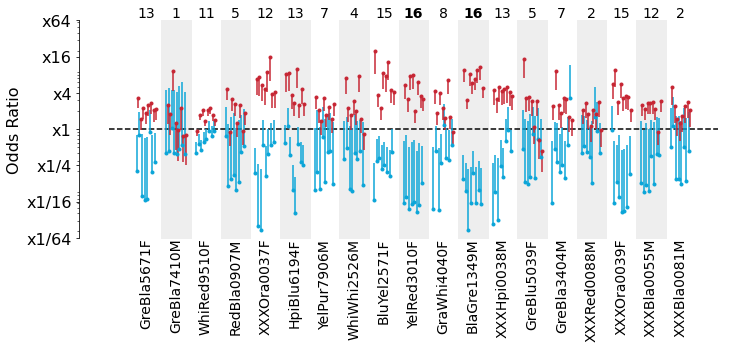

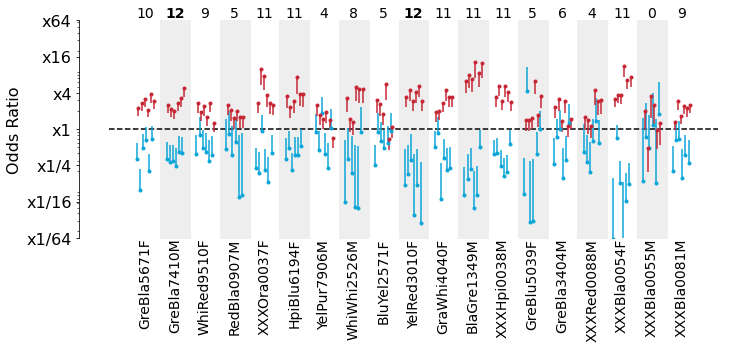

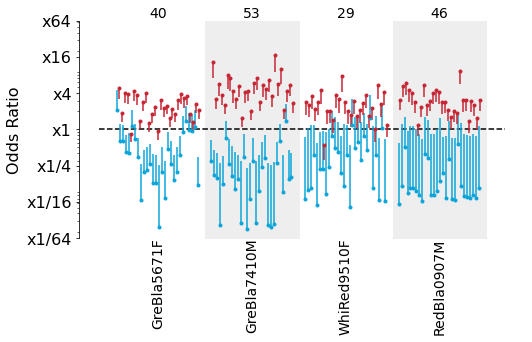

In [169]:
yscale = [-6, 6]

for test in ["SovsSo_8v8_d2", "DCvsDC_6v6_d2", "AllvsAll_28v28"]:
    fig_height = 4
    if test == "AllvsAll_28v28":
        fig = plt.figure(figsize=(8, fig_height))
    else:
        fig = plt.figure(figsize=(12, fig_height))

    test_df = stim_level_df[stim_level_df["Test Context"] == test]
    
    
    # Current x-position of points to plot
    base_plot_pos = 0
    
    # Flag to alternate background shading between subjects
    shade_flag = False
    
    # Counters for number of subjects in test and number of subjects who memorized full set
    n_full = 0
    n_subjects = 0
    n_half = 0

    for subject in test_df.Subject.unique():
        rewarded = test_df[(test_df.Subject == subject) & (test_df["Stimulus Class"] == "Rewarded")]
        nonrewarded = test_df[(test_df.Subject == subject) & (test_df["Stimulus Class"] == "Nonrewarded")]
        
        reward_x = np.arange(len(rewarded))
        nonreward_x = 0.5 + np.arange(len(nonrewarded))
        
        reward_err = rewarded["Odds Ratio"] - rewarded["95 CI Lower"], 
        plt.errorbar(
            base_plot_pos + reward_x,
            rewarded["Odds Ratio"],
            yerr=[
                [0] * len(rewarded),
                rewarded["95 CI Upper"] - rewarded["Odds Ratio"]
            ],
            color=color_by_reward.get("Rewarded"),
            marker=".",
            linestyle="none",
        )
        
        plt.errorbar(
            base_plot_pos + nonreward_x,
            nonrewarded["Odds Ratio"],
            yerr=[
                nonrewarded["Odds Ratio"] - nonrewarded["95 CI Lower"],
                [0] * len(nonrewarded)
            ],
            color=color_by_reward.get("Nonrewarded"),
            marker=".",
            linestyle="none",
        )
        
        # Shade in background alternatingly
        window_max = np.max(np.concatenate([reward_x, nonreward_x]))
        if shade_flag:
            plt.fill_between(
                [base_plot_pos - 2, base_plot_pos + window_max + 2],
                2**yscale[0], 2**yscale[1], zorder=-100, color="#EEEEEE"
            )
        
        midpt = base_plot_pos + (window_max / 2)
        sig_n, sig_max = mem_counts[(subject, test)]
        plt.text(
            midpt,
            2 ** yscale[1],
            "{}".format(sig_n),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontweight="bold" if sig_n == sig_max else None,
            fontsize=14,
        )
        plt.text(
            midpt,
            2 ** yscale[0],
            subject,
            horizontalalignment="center",
            verticalalignment="top",
            rotation=90,
            fontsize=14
        )
    
        shade_flag = not shade_flag
        base_plot_pos += window_max + 4
        
    ax = plt.gca()
    set_oddsratio_yticks(ax, biggest=yscale[1], smallest=yscale[0])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xticks([])

    plt.show()
    plt.close(fig)


## Learning curves

In [150]:
from functools import partial


def inject_relative_informative_trials(df):
    """Takes a dataframe with a subset of trials and injects a column of "Relative Informative Trials Seen"
    which indicates the number of informative trials seen by a subject for a given vocalizer in the
    selected range
    """
    df = df.copy()
    df["Relative Informative Trials Seen"] = df["Informative Trials Seen"]
    for (subj, vocalizer, call_type), subdf in df.groupby(["Subject", "Stimulus Vocalizer", "Stimulus Call Type"]):
        df.loc[
            subdf.index,
            "Relative Informative Trials Seen"
        ] -= subdf.iloc[0]["Informative Trials Seen"]
    
    return df


def generate_informative_trial_dataframe(df, informative_trials):
    """Generate a dataframe with interruption data per bin per subject per stimulus
    from the selected trials
    """
    # The "Informative Trials Seen" column counts informative trials seen for a given stim across
    # all sessions run for a subject. The given dataframe may only include trials from a selected
    # epoch which may not include the first sessions. So we create a new "Relative Informative Trials Seen"
    # column that shows number of informative trials seen relative to the start of the requested range.
    df = inject_relative_informative_trials(df)
    output_rows = []
    for bin_idx in informative_trials:
        bin_df = df[df["Relative Informative Trials Seen"] == bin_idx]
        for (subject, vocalizer, call_type, rewarded), stim_df in bin_df.groupby([
                    "Subject", "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class"
                ]):
            output_rows.append([
                subject,
                vocalizer,
                call_type,
                rewarded,
                bin_idx,
                len(stim_df),
                np.mean(stim_df["Interrupt"])  # This should be just 1 / len(stim_df)
            ])
            
    return pd.DataFrame(output_rows, columns=["Subject", "Stimulus Vocalizer", "Stimulus Call Type",
            "Stimulus Class", "Relative Informative Trials Seen", "Bin Size", "p(interrupt)"])


def process_learning_curve_data(df, informative_trials):
    """
    Collect probability of interruption across subjects in each informative trial bin
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    inform_df = generate_informative_trial_dataframe(df, informative_trials)
    
    grouped_by_informative_trials = inform_df.groupby([
        "Subject", "Relative Informative Trials Seen", "Stimulus Class"
    ]).mean()["p(interrupt)"]

    binned = grouped_by_informative_trials.groupby(
        ["Relative Informative Trials Seen", "Stimulus Class"],
    )
    
    output_rows = []
    for (bin_idx, rewarded), subdf in binned:
        output_rows.append([bin_idx, rewarded, np.mean(subdf), jackknife(subdf, np.mean)])
    output = pd.DataFrame(output_rows, columns=["Informative Trials", "Stimulus Class", "p(interrupt)", "SEM"])
    output = output.sort_values(["Informative Trials", "Stimulus Class"])

    return output


def plot_learning_curve(df, informative_trials, ax, fill_kwargs, n_sem=2, line_kwargs=None):
    """
    Plot the learning curve across subjects for the given trials
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    learning_df = process_learning_curve_data(df, informative_trials)
    
    for stimulus_class in ["Rewarded", "Nonrewarded"]:
        subdf = learning_df[learning_df["Stimulus Class"] == stimulus_class]
        ax.fill_between(
            subdf["Informative Trials"],
            subdf["p(interrupt)"] - 2 * subdf["SEM"],
            subdf["p(interrupt)"] + 2 * subdf["SEM"],
            color=color_by_reward.get(stimulus_class),
            **fill_kwargs
        )
        if line_kwargs is not None:
            ax.plot(
                subdf["Informative Trials"],
                subdf["p(interrupt)"],
                color=color_by_reward.get(stimulus_class),
                **line_kwargs
            )

In [151]:
def plot_learning_curves_side_by_side(df1, df2, informative_trials, ylim=(0, 1)):
    fig = plt.figure(figsize=(12, 4))

    ax_left = fig.add_axes([0.1, 0.1, 0.4, 0.8])
    ax_right = fig.add_axes([0.6, 0.1, 0.4, 0.8])

    plot_learning_curve(
        df1,
        informative_trials,
        ax_left,
        fill_kwargs=dict(
            alpha=0.2,
            zorder=-1,
        ),
        line_kwargs = dict(
            marker="x",
            markersize=8,
        )
    )

    plot_learning_curve(
        df2,
        informative_trials,
        ax_right,
        fill_kwargs=dict(
            alpha=0.4,
            zorder=-1,
        ),
        line_kwargs = dict(
            marker="o",
            markersize=5,
        )
    )

    for ax in [ax_left, ax_right]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        #Create legend from custom artist/label lists
        if ax is ax_right:
            unreartist = plt.Line2D((0,1),(0,0), color=color_by_reward.get("Unrewarded"), marker='', linestyle='-')
            reartist = plt.Line2D((0,1),(0,0), color=color_by_reward.get("Rewarded"), marker='', linestyle='-')
            dc_artist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='-', markersize=8)
            song_artist = plt.Line2D((0,1),(0,0), color='k', marker='x', linestyle='-')
            ax.legend(
                [unreartist, reartist, dc_artist, song_artist], 
                ["UnRe", "Re", "DC", "Song"],
                ncol=2, 
                frameon=False,
                fontsize=16
            )

        # Set limits and axes of plot
        ax.set_xlim(0, np.max(informative_trials))
        ax.set_xticks([0, 10, 20])
        ax.set_xticklabels([0, 10, 20], fontsize=16)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

        if ax is ax_left:
            ax.set_ylabel("Prob. of interruption", fontsize=16)
        ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)

        ax.set_ylim(*ylim)


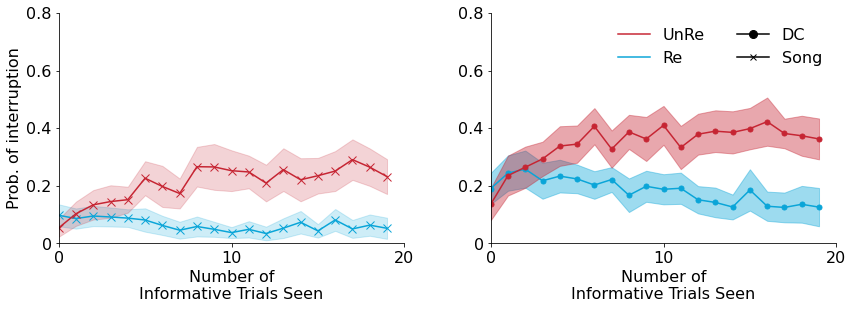

In [152]:
plot_learning_curves_side_by_side(
    df[df["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    df[df["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(20),
    ylim=(0, 0.8)
)

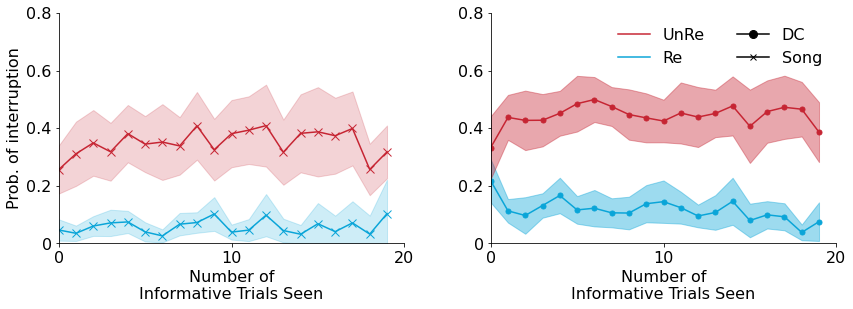

In [153]:
plot_learning_curves_side_by_side(
    df[df["Test Context"].isin(["SovsSo_8v8_d2"])],
    df[df["Test Context"].isin(["DCvsDC_6v6_d2"])],
    informative_trials=np.arange(20),
    ylim=(0, 0.8)
)

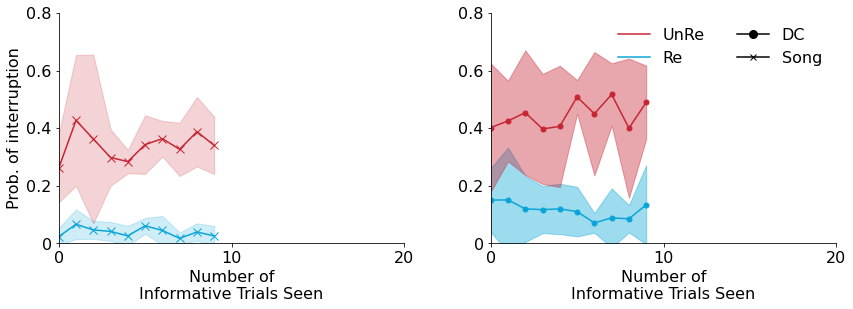

In [154]:
plot_learning_curves_side_by_side(
    df[
        df["Test Context"].isin(["AllvsAll_4v4", "AllvsAll_28v28"]) &
        (df["Stimulus Call Type"] == "SO") &
        (df["Condition"] == "None")
    ],
    df[
        df["Test Context"].isin(["AllvsAll_4v4", "AllvsAll_28v28"]) &
        (df["Stimulus Call Type"] == "DC") &
        (df["Condition"] == "None")
    ],
    informative_trials=np.arange(10),
    ylim=(0, 0.8)
)

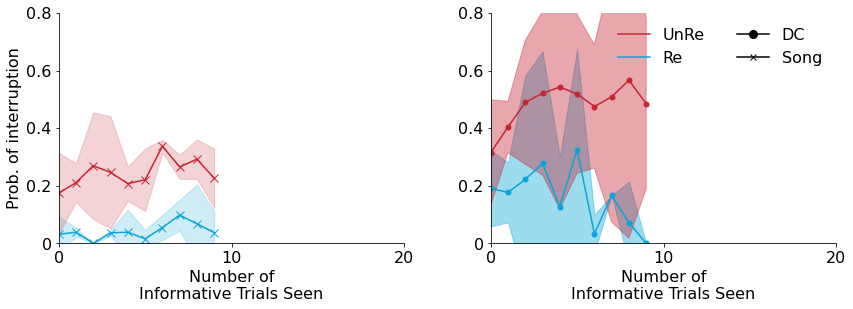

In [155]:
plot_learning_curves_side_by_side(
    df[
        df["Test Context"].isin(["AllvsAll_4v4", "AllvsAll_28v28"]) &
        (df["Stimulus Call Type"] == "SO") &
        (df["Condition"] == "MonthLater")
    ],
    df[
        df["Test Context"].isin(["AllvsAll_4v4", "AllvsAll_28v28"]) &
        (df["Stimulus Call Type"] == "DC") &
        (df["Condition"] == "MonthLater")
    ],
    informative_trials=np.arange(10),
    ylim=(0, 0.8)
)

## Generalization

Similar logic to Informative Trials analysis, but looking at the probability that any given subject will interrupt the kth heard rendition of a stimulus for any given vocalizer.

In [156]:
from functools import partial
from collections import defaultdict
from stats import linreg


def find_first_trial_per_rendition(df):
    """For each subject and vocalizer/calltype in the dataframe
    
    Make a row for the trial representing the very first time that file was presented
    """
    df = df.copy()
    
    def clean_stimulus_file(file):
        if file[-6:] in ["_0.wav", "_1.wav", "_2.wav", "_3.wav"]:
            file = file[:-6] + file[-4:]
        return file

    df["Stimulus File"] = df["Stimulus File"].apply(clean_stimulus_file)
    df["First Presentation of File"] = False
    df["kth Presentation of Vocalizer"] = np.nan

    stimulus_vocalizer_counts = defaultdict(int)
    for (subject, _, vocalizer, call_type), subdf in df.sort_values("Time").groupby([
                "Subject", "Stimulus File", "Stimulus Vocalizer", "Stimulus Call Type"
            ], sort=False):
        k = stimulus_vocalizer_counts[(subject, vocalizer, call_type)]
        subdf = subdf.sort_values("Time")
        df.loc[subdf.index[0], "First Presentation of File"] = True
        df.loc[subdf.index[0], "kth Presentation of Vocalizer"] = k
        stimulus_vocalizer_counts[(subject, vocalizer, call_type)] += 1
        
    result = df[df["First Presentation of File"] == True]
    return result


def collapse_first_trials_per_rendition(df):
    """Collapse the output of find_first_trial_per_rendition across vocalizers
    """
    df = find_first_trial_per_rendition(df)
    output_rows = []
    for (subject, kth_presentation, call_type, stimulus_class), subdf in df.groupby([
                "Subject", "kth Presentation of Vocalizer", "Stimulus Call Type", "Stimulus Class"
            ]):
        output_rows.append([
            subject,
            kth_presentation,
            call_type,
            stimulus_class,
            np.mean(subdf["Interrupt"])
        ])
    return pd.DataFrame(output_rows,
            columns=["Subject", "kth Presentation", "Call Type", "Class", "p(interrupt)"])


def group_by_kth_presentation(df):
    df = collapse_first_trials_per_rendition(df)
    
    output_rows = []
    for (kth_presentation, stimulus_class, call_type), subdf in df.groupby(["kth Presentation", "Class", "Call Type"]):
        p = subdf["p(interrupt)"]
        mean_p = np.mean(p)
        sem = jackknife(p, np.mean)
        
        output_rows.append([
            kth_presentation,
            stimulus_class,
            call_type,
            mean_p,
            sem
        ])
    return pd.DataFrame(output_rows,
        columns=["kth Presentation", "Class", "Call Type", "p(interrupt)", "SEM"])

In [157]:
result = group_by_kth_presentation(df)

In [158]:
result

,kth Presentation,Class,Call Type,p(interrupt),SEM
0,0.0,Nonrewarded,DC,0.241667,0.038664
1,0.0,Nonrewarded,SO,0.093750,0.025849
2,0.0,Rewarded,DC,0.320833,0.047709
3,0.0,Rewarded,SO,0.171875,0.030711
4,1.0,Nonrewarded,DC,0.379167,0.059688
5,1.0,Nonrewarded,SO,0.187500,0.038206
6,1.0,Rewarded,DC,0.429167,0.043291
7,1.0,Rewarded,SO,0.206250,0.038501
8,2.0,Nonrewarded,DC,0.362500,0.039308
9,2.0,Nonrewarded,SO,0.231250,0.037963


Song Rewarded R2 = 0.75 R2_adj = 0.71
Song Nonrewarded R2 = 0.92 R2_adj = 0.90


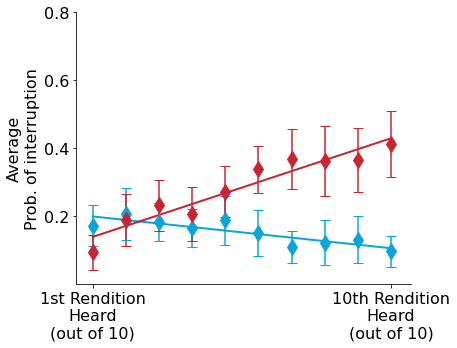

DC Rewarded R2 = 0.11 R2_adj = -0.00
DC Nonrewarded R2 = 0.83 R2_adj = 0.81


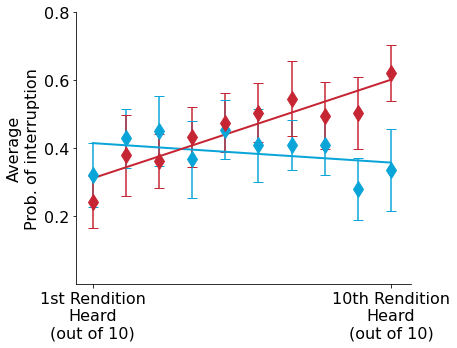

In [159]:
fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Average\nProb. of interruption", fontsize=16)

plt.show()
plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Average\nProb. of interruption", fontsize=16)

plt.show()
plt.close(fig)


## Month later recall

If you take all trials before the first (N) informative trials in a given epoch, what is the probabiliy if interrupting (rewarded vs unrewarded)

In [160]:
month_later_epoch = df[
    (df["Condition"] == "MonthLater") & (df["Test Context"].apply(lambda x: x.startswith("AllvsAll")))
]

In [161]:
valid_subjects = month_later_epoch.Subject.unique()

In [162]:
epoch1 = df[(df["Condition"] != "MonthLater") & (df.Subject.isin(valid_subjects))]
epoch2 = df[
    (df["Condition"] != "MonthLater") &
    (df["Test Context"].apply(lambda x: x.startswith("AllvsAll"))) &
    (df.Subject.isin(valid_subjects))
]

In [163]:
# For each subject, for each informative trials limit, for each call type, for each reward class
informative_trials_limit = 2

output_rows = []

for epoch_name, epoch in [("Naive", epoch1), ("Learned", epoch2), ("MonthLater", month_later_epoch)]:
    epoch = inject_relative_informative_trials(epoch)
    for (subject, call_type, rewarded), epoch_grouped in epoch.groupby(["Subject", "Stimulus Call Type", "Stimulus Class"]):
        
        interruption_probabilities = []
        for vocalizer, stim_df in epoch_grouped.groupby(["Stimulus Vocalizer"]):
            subdf = stim_df[stim_df["Relative Informative Trials Seen"] <= informative_trials_limit]
            interruption_probabilities.append(np.mean(subdf["Interrupt"]))
        
        output_rows.append([
            subject,
            informative_trials_limit,
            call_type,
            rewarded,
            epoch_name,
            interruption_probabilities,
            np.mean(interruption_probabilities),
            jackknife(interruption_probabilities, np.mean)
        ])
            
result = pd.DataFrame(output_rows, columns=[
    "Subject", 
    "Informative Trials", 
    "Stimulus Call Type",
    "Stimulus Class", 
    "Epoch",
    "p(interrupt,stim)",
    "p(interrupt)",
    "SEM",
])
result

,Subject,Informative Trials,Stimulus Call Type,Stimulus Class,Epoch,"p(interrupt,stim)",p(interrupt),SEM
0,GreBla5671F,2,DC,Nonrewarded,Naive,"[0.25, 0.25, 0.7857142857142857, 0.4, 0.625, 0...",0.485913,0.071559
1,GreBla5671F,2,DC,Rewarded,Naive,"[0.625, 0.0, 0.25, 0.0, 0.5, 0.4, 0.25, 0.625,...",0.380769,0.069666
2,GreBla5671F,2,SO,Nonrewarded,Naive,"[0.25, 0.4, 0.25, 0.0, 0.0, 0.5, 0.0, 0.25, 0....",0.134375,0.042505
3,GreBla5671F,2,SO,Rewarded,Naive,"[0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.5, 0.25, 0.7...",0.162500,0.055057
4,GreBla7410M,2,DC,Nonrewarded,Naive,"[0.25, 0.5, 0.7272727272727273, 0.25, 0.0, 0.4...",0.298801,0.090353
5,GreBla7410M,2,DC,Rewarded,Naive,"[0.25, 0.5, 0.0, 0.5, 0.0, 0.0, 0.25, 0.7, 0.5...",0.349702,0.072019
6,GreBla7410M,2,SO,Nonrewarded,Naive,"[0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.25, 0.4,...",0.192187,0.054664
7,GreBla7410M,2,SO,Rewarded,Naive,"[0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.4, 0.0, 0.25...",0.103125,0.042197
8,GreBla5671F,2,DC,Nonrewarded,Learned,"[0.8636363636363636, 0.7, 0.75, 0.4, 0.7857142...",0.698259,0.037281
9,GreBla5671F,2,DC,Rewarded,Learned,"[0.4, 0.5714285714285714, 0.5, 0.5714285714285...",0.351488,0.060218


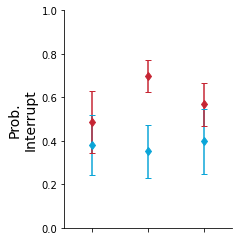

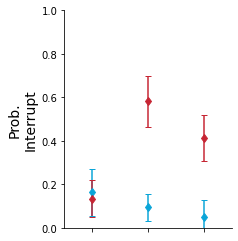

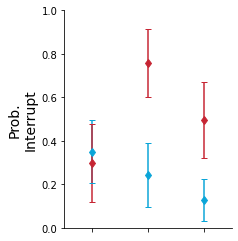

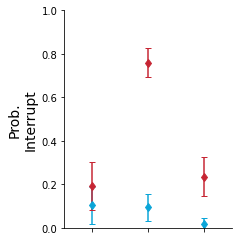

In [164]:
for (subject, call_type), subdf in result.groupby(["Subject", "Stimulus Call Type"]):
    fig = plt.figure(figsize=(3, 4))
    for i, epoch in enumerate(["Naive", "Learned", "MonthLater"]):
        p_rew = subdf[(subdf["Epoch"] == epoch) & (subdf["Stimulus Class"] == "Rewarded")].iloc[0]["p(interrupt)"]
        sem_rew = subdf[(subdf["Epoch"] == epoch) & (subdf["Stimulus Class"] == "Rewarded")].iloc[0]["SEM"]
        p_norew = subdf[(subdf["Epoch"] == epoch) & (subdf["Stimulus Class"] == "Nonrewarded")].iloc[0]["p(interrupt)"]
        sem_norew = subdf[(subdf["Epoch"] == epoch) & (subdf["Stimulus Class"] == "Nonrewarded")].iloc[0]["SEM"]

        plt.errorbar(
            [i], 
            [p_rew],
            yerr=2*sem_rew,
            marker="d",
            capsize=3,
            color=color_by_reward.get("Rewarded"),
        )
        plt.errorbar(
            [i],
            [p_norew],
            yerr=2*sem_norew,
            marker="d",
            capsize=3,
            color=color_by_reward.get("Unrewarded"),
        )
        
        ax = plt.gca()
        ax.set_ylabel("Prob.\nInterrupt", fontsize=14)

        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(0, 1)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(True)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["", "", ""])

    plt.show()
    plt.close(fig)


In [165]:
# Second learning curve

In [166]:
def process_learning_curve_data(df, informative_trials):
    """
    Collect probability of interruption across subjects in each informative trial bin
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    inform_df = generate_informative_trial_dataframe(df, informative_trials)
    
    grouped_by_informative_trials = inform_df.groupby([
        "Subject", "Relative Informative Trials Seen", "Stimulus Class"
    ]).mean()["p(interrupt)"]

    binned = grouped_by_informative_trials.groupby(
        ["Relative Informative Trials Seen", "Stimulus Class"],
    )
    
    output_rows = []
    for (bin_idx, rewarded), subdf in binned:
        output_rows.append([bin_idx, rewarded, np.mean(subdf), jackknife(subdf, np.mean)])
    output = pd.DataFrame(output_rows, columns=["Informative Trials", "Stimulus Class", "p(interrupt)", "SEM"])
    output = output.sort_values(["Informative Trials", "Stimulus Class"])

    return output


In [171]:
# import statsmodels.formula.api as smf
# result["InterruptInt"] = result["Interrupt"].astype(np.int)
# md = smf.mixedlm(
#     "InterruptInt ~ "
#     "Q(\"kth Presentation of Vocalizer\") + "
#     "Q(\"Stimulus Call Type\") +"
#     "Q(\"Stimulus Class\") +"
#     "Q(\"kth Presentation of Vocalizer\") * Q(\"Stimulus Class\") +"
#     "Q(\"kth Presentation of Vocalizer\") * Q(\"Stimulus Call Type\")",
#     result,
#     groups=result["Subject"])
# mdf = md.fit()
# summary = mdf.summary()
